# Fighting Overfitting

In [1]:
import sklearn.metrics
import numpy as np
import jax
import jax.numpy as jnp
from typing import List
import pandas as pd
import numpy.random as rng
import matplotlib.pyplot as plt

In [48]:
def prepare_inputs(input_df):
    """
        Prepares the input features that will be fed into the model.

        Inputs:
            input_df: the input dataframe into the function. Should consist ONLY of input features.
        Outputs:
            Z: the input feature matrix of size NxK, where K is the number of features
    """
    # Let's identify categorical columns in a dataframe
    categorical_cols = input_df.select_dtypes(include='object').columns
    
    # Let's identify the numeric columns in the dataframe
    numeric_cols = input_df.select_dtypes(include='number').columns

    # We want to construct the input features into the model
    # We will use a numpy array that contains both numeric and categorically encoded values
    X = input_df[numeric_cols].to_numpy() # (NxK)
    
    # Now we need to z-score the numeric features so that they can lead to efficient learning
    col_means = np.mean(X, axis=0) # K
    col_stds = np.std(X, axis=0, ddof=1) # K
    
    # Z-score
    # (NxK - 
    #  1xK) 
    #  / 
    #  (1xK)
    Z = (X - col_means[None, :]) / col_stds[None, :]
    
    # Now we want to code the categorical columns using one-hot encoding
    for col in categorical_cols:
        # NxC (C is the number of unique values in the column)
        # So for origin this will be Nx3 
        dummies = pd.get_dummies( input_df[col] ).to_numpy() 
        
        # concatenate dummies matrix onto Z
        #print(Z.shape)
        #print(dummies.shape)
        Z = np.hstack((Z, dummies)) 
    
    # finally we want to add a column of ones at the start of Z
    ones_col = np.ones((Z.shape[0], 1)) # Nx1
    
    Z = np.hstack((ones_col, Z))

    return Z

def forward_fn(params, Z):
    """
        MLP forward function: implements an MLP with one hidden layer of relu units.
       
        Inputs:
            params: the coefficients of the model (size K)
            Z: the input feature matrix, as returned by prepare_inputs (size NxK)
        Output:
            yhat: the model's predictions (size N)
    """
    # NxM @ MxH = NxH
    h = jnp.maximum(0, Z @ params['W_ih']) # RELU activation
    #h = jnp.tanh(Z @ params['W_ih'])
    f = h @ params['W_ho'] + params['b_o'] # NxH @ H = N
    p = 1/(1+jnp.exp(-f))
    return p 

def predict(params, input_df):
    """
        Convienience function that prepares inputs and runs the forward function.

        Inputs:
            params: the weights of the model (size K)
            input_df: input data frame (input features only, no output column).
        Output:
            yhat: the model's predictions (size N)
    """
    Z = prepare_inputs(input_df)
    return forward_fn(params, Z)

def loss_fn(params, Z, y):
    """
        Computes the negative cross-entropy loss function for the model.

        Inputs:
            params: the weights of the model (size K)
            Z: the input feature matrix, as returned by prepare_inputs (size NxK)
            y: actual observations (size N)
        Output:
            loss: negative binary cross entropy
    """
    yhat = forward_fn(params, Z)
    loss = -jnp.mean(y * jnp.log(yhat) + (1-y) * jnp.log(1-yhat))
    return loss 

def optimize(rng, input_df, y, learning_rate, epochs, n_hidden, epoch_callback_fn = None):
    """
        Input parameters:
            rng: JAX random key
            input_df: dataframe containing input columns
            y: a vector of outputs that we wish to predict
            learning_rate: how quickly we want gradient descent learning
            epochs: the number of steps of gradient descent
            n_hidden: number of hidden units
            epoch_callback_fn: an optional function that gets called with the current parameter values after every epoch
        Output:
            Beta: fitted model parameters
    """
    
    # move y into jax's domain
    y = jnp.array(y) # <-- JAX

    # Create a function that computes the gradient of the loss_fn with respect to the first argument (Beta)
    grad_fn = jax.grad(loss_fn) # <-- JAX

    # Prepare our inputs 
    Z = prepare_inputs(input_df) # NxK
    
    # split data into optimization and validation for early stopping
    prop_opt = 0.8
    n_opt = int(prop_opt * y.shape[0])
    y_opt, y_valid = y[:n_opt], y[n_opt:]
    Z_opt, Z_valid = Z[:n_opt,:], Z[n_opt:]

    # Randomly initialize our solution 
    rng2, rng3, rng4 = jax.random.split(rng, 3)
    params = dict(
        # Weights from input to hidden layer
        W_ih = jax.random.normal(rng, (Z.shape[1], n_hidden)) * jnp.sqrt(1/Z.shape[1]), 

        # Weights from hidden to output neuron
        W_ho = jax.random.normal(rng2, n_hidden) * jnp.sqrt(1/n_hidden),

        # Bias of the output neuron
        b_o = jax.random.normal(rng3)
    )

    epochs_since_last_good_valid_loss = 0
    patience = 10
    best_valid_loss = jnp.inf 
    best_params = None 

    # Run gradient descent loop
    for i in range(epochs):

        # compute gradient
        W_grad = grad_fn(params, Z_opt, y_opt)
                
        # update solution
        params['W_ih'] = params['W_ih'] - learning_rate * W_grad['W_ih']
        params['W_ho'] = params['W_ho'] - learning_rate * W_grad['W_ho']
        params['b_o'] = params['b_o'] - learning_rate * W_grad['b_o']


        train_loss = loss_fn(params, Z, y)
        if epoch_callback_fn:
            epoch_callback_fn(params, train_loss)

        # evaluate on validation set
        valid_loss = loss_fn(params, Z_valid, y_valid)

        if valid_loss < best_valid_loss:
            # if new best validation loss, record parameters and reset patience counter
            best_valid_loss = valid_loss
            best_params = params 
            epochs_since_last_good_valid_loss = 0
        else:
            # not new best, update epochs since last best
            epochs_since_last_good_valid_loss += 1
        
        # ran out of patience
        if epochs_since_last_good_valid_loss == patience:
            break 
        
    
    return best_params

# We will create little function that takes the training dataframe and the testing dataframe
def mlp_train_test_function(rng, train_df, test_df, input_cols, output_col, n_hidden):

    # build the training input data frame
    train_input_df = train_df[input_cols]

    # build the training outputs
    y = train_df[output_col].to_numpy()
    
    # Optimize the model using gradient descent
    best_params = optimize(rng,
                           input_df = train_input_df,
                           y = y,
                           learning_rate = 0.1,
                           epochs = 100,
                           n_hidden=n_hidden)

    # build the testing input data frame
    test_input_df = test_df[input_cols]

    # Make predictions on the test set
    yhat = predict(params = best_params,
                   input_df = test_input_df)
    
    # Calculate error of those predictions
    ytest = test_df[output_col].to_numpy()
    
    # we'll use accuracy for now
    return sklearn.metrics.accuracy_score(ytest, yhat > 0.5)

In [49]:

df = pd.read_csv("../data/sonar.csv", header=None)
print(df)

# randomly shuffle cuz we want to split it into training and testing
df = df.sample(frac=1, random_state=234234)

# get all columns, except last one
input_cols = df.columns[:-1]

# get last column
output_col = df.columns[-1]
df['y'] = df[output_col] == 'M'
output_col = 'y'

rng = jax.random.key(42)

#
# randomly split dataset
#
prop = 0.8
n_train = int(df.shape[0] * prop) # compute number of training entries
train_df = df.iloc[:n_train] # grab first n_train entries
test_df = df.iloc[n_train:] # grab the remaining entries

# function that will be called after every epoch
train_losses = []
test_losses = []
def epoch_callback_fn(params, loss):
    train_losses.append(loss)

    # evaluate the model after every epoch,
    # you don't do this in real-world but this just for illustration
    Z = prepare_inputs(test_df[input_cols])
    test_loss = loss_fn(params, Z, test_df[output_col].to_numpy())
    test_losses.append(test_loss)

# Optimize the model using gradient descent
best_params = optimize(rng,
                       input_df = train_df[input_cols],
                       y = train_df[output_col],
                       learning_rate = 0.1,
                       epochs = 500,
                       n_hidden=2,
                       epoch_callback_fn=epoch_callback_fn)


         0       1       2       3       4       5       6       7       8   \
0    0.0200  0.0371  0.0428  0.0207  0.0954  0.0986  0.1539  0.1601  0.3109   
1    0.0453  0.0523  0.0843  0.0689  0.1183  0.2583  0.2156  0.3481  0.3337   
2    0.0262  0.0582  0.1099  0.1083  0.0974  0.2280  0.2431  0.3771  0.5598   
3    0.0100  0.0171  0.0623  0.0205  0.0205  0.0368  0.1098  0.1276  0.0598   
4    0.0762  0.0666  0.0481  0.0394  0.0590  0.0649  0.1209  0.2467  0.3564   
..      ...     ...     ...     ...     ...     ...     ...     ...     ...   
203  0.0187  0.0346  0.0168  0.0177  0.0393  0.1630  0.2028  0.1694  0.2328   
204  0.0323  0.0101  0.0298  0.0564  0.0760  0.0958  0.0990  0.1018  0.1030   
205  0.0522  0.0437  0.0180  0.0292  0.0351  0.1171  0.1257  0.1178  0.1258   
206  0.0303  0.0353  0.0490  0.0608  0.0167  0.1354  0.1465  0.1123  0.1945   
207  0.0260  0.0363  0.0136  0.0272  0.0214  0.0338  0.0655  0.1400  0.1843   

         9   ...      51      52      53      54   

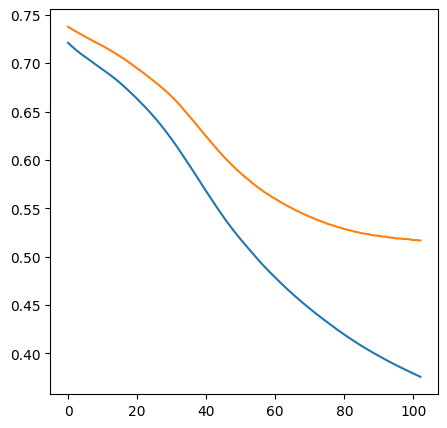

In [50]:
f, ax = plt.subplots(1,1,figsize=(5,5))
ax.plot(np.arange(len(train_losses)), train_losses)
ax.plot(np.arange(len(test_losses)), test_losses)